Running Uniform Replay Agent...
Running Uncertainty (Prioritized) Replay Agent...


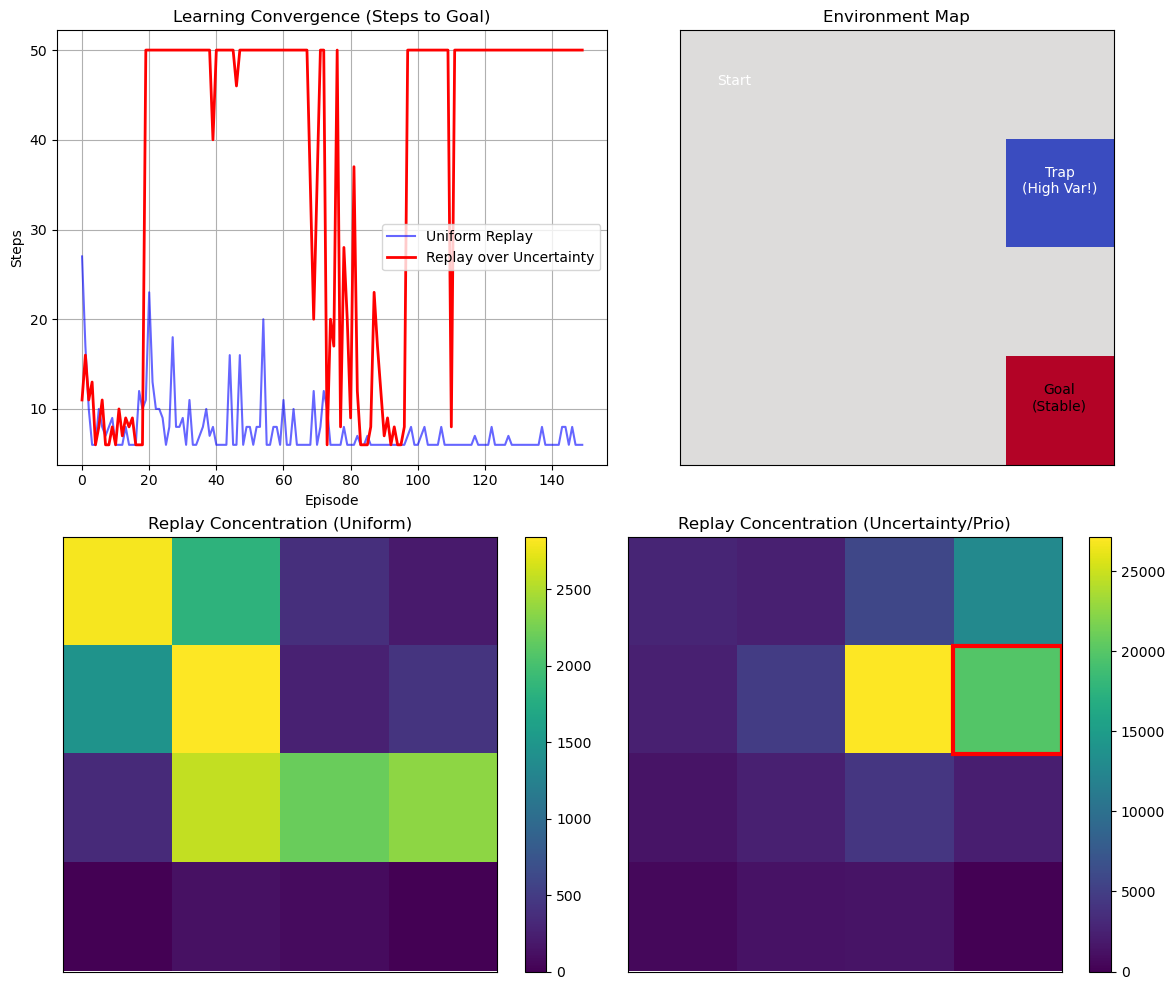

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque

# ===========================
# 1. The Stochastic Environment
# ===========================
class StochasticGridWorld:
    def __init__(self):
        self.height = 4
        self.width = 4
        self.start_state = (0, 0)
        self.goal_state = (3, 3)
        # The Trap has high variance rewards
        self.trap_state = (1, 3) 
        self.agent_pos = self.start_state

    def reset(self):
        self.agent_pos = self.start_state
        return self.agent_pos

    def step(self, action):
        # Actions: 0:up, 1:down, 2:left, 3:right
        y, x = self.agent_pos
        if action == 0: y = max(y - 1, 0)
        elif action == 1: y = min(y + 1, self.height - 1)
        elif action == 2: x = max(x - 1, 0)
        elif action == 3: x = min(x + 1, self.width - 1)
        
        next_state = (y, x)
        self.agent_pos = next_state
        
        done = False
        reward = -0.1 # Step cost

        if next_state == self.goal_state:
            # Goal: High mean, very low variance
            reward = np.random.normal(loc=20, scale=0.5)
            done = True
        elif next_state == self.trap_state:
            # Trap: Negative mean, EXTREMELY HIGH variance (Uncertainty)
            # It might give +5 or -25 randomly.
            reward = np.random.normal(loc=-5, scale=25.0)
            # Ensure it doesn't end episode immediately so agent feels the pain
            done = False 

        return next_state, reward, done

# ===========================
# 2. The Replay Buffers
# ===========================
class UniformBuffer:
    def __init__(self, capacity=2000):
        self.buffer = deque(maxlen=capacity)
    
    def add(self, experience, priority=None):
        # Priority ignored in uniform buffer
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size), None, None

class PrioritizedBuffer:
    """Simplified PER: Sampling probability proportional to prediction error priority"""
    def __init__(self, capacity=2000, alpha_prio=0.6):
        self.buffer = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)
        self.alpha_prio = alpha_prio # How much priority matters
        self.epsilon_prio = 1e-5 # Small constant to ensure non-zero probability

    def add(self, experience, priority):
        self.buffer.append(experience)
        self.priorities.append(max(priority, self.epsilon_prio))

    def sample(self, batch_size):
        if len(self.buffer) == 0: return [], [], []
        
        # Calculate sampling probabilities based on priorities
        scaled_priorities = np.array(self.priorities) ** self.alpha_prio
        probs = scaled_priorities / sum(scaled_priorities)
        
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[i] for i in indices]
        
        # Important issues: Importance Sampling Weights would usually go here 
        # for bias correction, but omitted for simulation simplicity.
        return samples, indices, probs[indices]

    def update_priorities(self, indices, new_priorities):
        for idx, prio in zip(indices, new_priorities):
            self.priorities[idx] = max(prio, self.epsilon_prio)

# ===========================
# 3. The Q-Learning Agent
# ===========================
class QAgent:
    def __init__(self, grid_size, buffer_type="uniform", epsilon=0.3):
        self.q_table = np.zeros((grid_size[0], grid_size[1], 4))
        self.lr = 0.1    # Learning Rate
        self.gamma = 0.95 # Discount Factor
        self.epsilon = epsilon
        self.grid_size = grid_size
        
        if buffer_type == "uniform":
            self.buffer = UniformBuffer()
            self.prioritized = False
        else:
            self.buffer = PrioritizedBuffer()
            self.prioritized = True
            
        # For visualization: track where replays happen
        self.replay_heatmap = np.zeros(grid_size)

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(4) # Explore
        else:
            y, x = state
            # Exploit: choose best action, break ties randomly
            q_values = self.q_table[y, x]
            max_q = np.max(q_values)
            actions_with_max_q = np.where(q_values == max_q)[0]
            return np.random.choice(actions_with_max_q)

    def calculate_td_error(self, s, a, r, s_next, done):
        """Calculates the 'Surprise'"""
        y, x = s
        y_next, x_next = s_next
        
        current_q = self.q_table[y, x, a]
        if done:
            target_q = r
        else:
            target_q = r + self.gamma * np.max(self.q_table[y_next, x_next])
            
        td_error = target_q - current_q
        return td_error

    def train_step(self, s, a, r, s_next, done):
        # 1. Calculate initial TD error (surprise) for priority
        td_error = self.calculate_td_error(s, a, r, s_next, done)
        
        # 2. Store experience with priority (absolute TD error)
        priority = np.abs(td_error)
        self.buffer.add((s, a, r, s_next, done), priority)
        
        # 3. Perform online update (optional, but standard Q-learning)
        self.q_table[s[0], s[1], a] += self.lr * td_error

    def replay(self, batch_size=32):
        if len(self.buffer.buffer) < batch_size: return

        samples, indices, _ = self.buffer.sample(batch_size)
        new_priorities = []

        for i, (s, a, r, s_next, done) in enumerate(samples):
            # Track replay location for visualization
            self.replay_heatmap[s] += 1 
            
            # Recalculate TD error with current Q-table values
            td_error = self.calculate_td_error(s, a, r, s_next, done)
            
            # Update Q-table
            self.q_table[s[0], s[1], a] += self.lr * td_error
            
            if self.prioritized:
                new_priorities.append(np.abs(td_error))

        if self.prioritized:
            self.buffer.update_priorities(indices, new_priorities)

# ===========================
# 4. Simulation Loop
# ===========================
def run_experiment(agent_type, episodes=150):
    env = StochasticGridWorld()
    agent = QAgent((4,4), buffer_type=agent_type)
    
    steps_per_episode = []
    
    for ep in range(episodes):
        state = env.reset()
        done = False
        steps = 0
        
        # Decay epsilon (exploration rate)
        agent.epsilon = max(0.01, agent.epsilon * 0.98)
        
        while not done and steps < 50: # Limit steps per episode
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            
            # Online training step (and store in buffer)
            agent.train_step(state, action, reward, next_state, done)
            state = next_state
            steps += 1
            
            # Perform Replay frequently
            agent.replay(batch_size=16)
            
        steps_per_episode.append(steps)
        # print(f"{agent_type} Episode {ep}: Steps {steps}")
        
    return steps_per_episode, agent.replay_heatmap

# Run both agents
print("Running Uniform Replay Agent...")
steps_uniform, heatmap_uniform = run_experiment("uniform")
print("Running Uncertainty (Prioritized) Replay Agent...")
steps_prio, heatmap_prio = run_experiment("prioritized")


# ===========================
# 5. Visualization
# ===========================
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Learning Curves
ax_lc = axes[0, 0]
ax_lc.plot(steps_uniform, label='Uniform Replay', alpha=0.6, color='blue')
ax_lc.plot(steps_prio, label='Replay over Uncertainty', linewidth=2, color='red')
ax_lc.set_title("Learning Convergence (Steps to Goal)")
ax_lc.set_xlabel("Episode")
ax_lc.set_ylabel("Steps")
ax_lc.legend()
ax_lc.grid(True)

# Plot 2: Environment Map
ax_map = axes[0, 1]
grid_map = np.zeros((4,4))
grid_map[3,3] = 1 # Goal
grid_map[1,3] = -1 # Trap
ax_map.imshow(grid_map, cmap='coolwarm', vmin=-1, vmax=1)
ax_map.text(0,0, 'Start', ha='center', color='white')
ax_map.text(3,3, 'Goal\n(Stable)', ha='center', color='black')
ax_map.text(3,1, 'Trap\n(High Var!)', ha='center', color='white')
ax_map.set_title("Environment Map")
ax_map.set_xticks([])
ax_map.set_yticks([])

# Plot 3: Heatmap of Uniform Replays
ax_hm_u = axes[1, 0]
im_u = ax_hm_u.imshow(heatmap_uniform, cmap='viridis')
ax_hm_u.set_title("Replay Concentration (Uniform)")
plt.colorbar(im_u, ax=ax_hm_u)
ax_hm_u.set_xticks([])
ax_hm_u.set_yticks([])

# Plot 4: Heatmap of Uncertainty Replays
ax_hm_p = axes[1, 1]
im_p = ax_hm_p.imshow(heatmap_prio, cmap='viridis')
ax_hm_p.set_title("Replay Concentration (Uncertainty/Prio)")
plt.colorbar(im_p, ax=ax_hm_p)
ax_hm_p.set_xticks([])
ax_hm_p.set_yticks([])
# Highlight the trap on this heatmap
rect = plt.Rectangle((2.5, 0.5), 1, 1, linewidth=3, edgecolor='red', facecolor='none')
ax_hm_p.add_patch(rect)


plt.tight_layout()
plt.show()